In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd
from typing import Dict, List
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from scipy.stats import norm, shapiro, kstest

C:\Users\Влада\AppData\Local\Temp\ipykernel_9524\3568833598.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [3]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

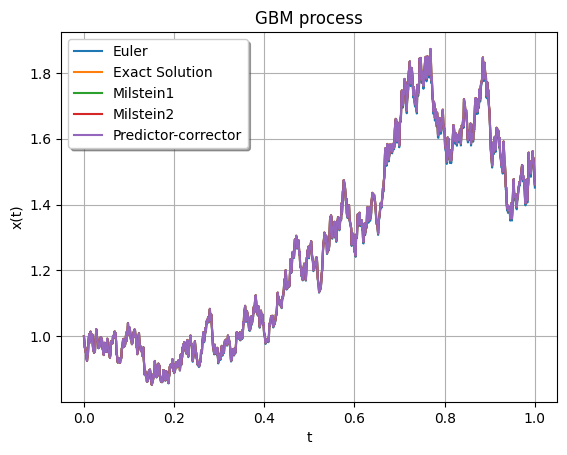

In [4]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


In [5]:
class ApproximationRunner:
    def __init__(self, model: StochasticProcess):
        self.model = model

    def start(self, discretization_state: int) -> Dict[str, Dict[str, np.ndarray]]:
        dwt = np.random.normal(0, 1, size=(self.model.Nt, self.model.Nx)) * np.sqrt(self.model.T / discretization_state)
        approximations = {}

        methods = {
            'exact': self.model.ExactSolution,
            'euler': self.model.EulerSolution,
            'milstein1': self.model.Milstein1Solution,
            'milstein2': self.model.Milstein2Solution,
            'predictor_corrector': lambda dwt: self.model.PredictorCorrectorSolution(dwt, 1/2, 1/2)
            # 'KPS': self.model.KPS_Solution
        }

        for method_name, method_func in methods.items():
            t_data, x_data = method_func(dwt)
            approximations[method_name] = {'t_data': t_data, 'x_data': x_data}

        return approximations

    def compare_approximations(self, levels_of_N: List[int]) -> pd.DataFrame:
        results = []

        for N in levels_of_N:
            self.model.Nt = N
            approximations = self.start(N)
            exact_data = approximations['exact']['x_data']

            # calculate maximum absolute difference for each method
            for method, data in approximations.items():
                if method != 'exact':
                    max_diff = np.max(np.abs(exact_data - data['x_data']))
                    results.append([N, method, max_diff])

        results_df = pd.DataFrame(results, columns=["N (subintervals)", "Method", "Max Absolute Difference"])
        return results_df

    def study_alpha_eta(self, alphas: np.ndarray, etas: np.ndarray) -> np.ndarray:
        
        dt = self.model.T / self.model.Nt
        dwt = np.random.normal(0, 1, size=(self.model.Nt, self.model.Nx)) * np.sqrt(dt)
        
        _, exact_solution = self.model.ExactSolution(dwt)
        
        errors = np.zeros((len(alphas), len(etas)))
        
        for i, alpha in enumerate(alphas):
            for j, eta in enumerate(etas):
                _, approx_solution = self.model.PredictorCorrectorSolution(dwt, eta=eta, alpha=alpha)
                errors[i, j] = np.max(np.abs(exact_solution - approx_solution))
        
        return errors
        
    def plot_error_surface(self, alphas: np.ndarray, etas: np.ndarray, errors: np.ndarray):
        alpha_grid, eta_grid = np.meshgrid(alphas, etas)
    
        fig = go.Figure(data=[go.Surface(z=errors.T, x=alpha_grid, y=eta_grid, colorscale='Greys')])
    
        fig.update_layout(
            title='Error Surface',
            scene=dict(
                xaxis_title=r'$alpha$',
                yaxis_title=r'$eta$',
                zaxis_title='Max Absolute Error',
            ),
            autosize=True,
            width=800,
            height=600,
        )
        fig.show()

    def compare_speed_convergence(self, levels_of_N: List[int]) -> pd.DataFrame:
        results = []
        
        for N in levels_of_N:
            self.model.Nt = N
            approximations = self.start(N)
            exact_data = approximations['exact']['x_data']
        
            # Calculate mean absolute difference for each method
            for method, data in approximations.items():
                if method != 'exact':
                    mean_diff = np.mean(np.abs(exact_data - data['x_data']))
                    results.append([np.log2(N), method, mean_diff])
        
        # Create DataFrame with log2(N), Method, and Mean Absolute Difference columns
        results_df = pd.DataFrame(results, columns=["log2(N)", "Method", "Mean Absolute Difference"])
        return results_df

In [6]:
theta1, theta2, x0, T, Nx =1, 0.5,  1, 1, 1
params = [theta1, theta2]
init_state = x0 * np.ones(Nx)


levels_of_N = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]
model =  BSMprocess(params, T, Nx, levels_of_N[0], init_state)
runner = ApproximationRunner(model)

results_df = runner.compare_approximations(levels_of_N)
results_df

N (subintervals)               Method  Max Absolute Difference
0                  2                euler                 0.054052
1                  2            milstein1                 0.221727
2                  2            milstein2                 0.044750
3                  2  predictor_corrector                 0.004738
4                  4                euler                 0.093471
5                  4            milstein1                 0.090459
6                  4            milstein2                 0.024227
7                  4  predictor_corrector                 0.006325
8                  8                euler                 0.602153
9                  8            milstein1                 0.540367
10                 8            milstein2                 0.052633
11                 8  predictor_corrector                 0.100113
12               128                euler                 0.025359
13               128            milstein1                 0.050974
14               128            milstein2                 0.002469
15               128  predictor_corrector                 0.002294
16               256                euler                 0.034369
17               256            milstein1                 0.019154
18               256            milstein2                 0.001264
19               256  predictor_corrector                 0.002930
20               512                euler                 0.058327
21               512            milstein1                 0.005620
22               512            milstein2                 0.000487
23               512  predictor_corrector                 0.000991
24              1024                euler                 0.045828
25              1024            milstein1                 0.003851
26              1024            milstein2                 0.000204
27              1024  predictor_corrector                 0.000465
28              8192                euler                 0.007063
29              8192            milstein1                 0.000125
30              8192            milstein2                 0.000018
31              8192  predictor_corrector                 0.000009
32             16384                euler                 0.005048
33             16384            milstein1                 0.000125
34             16384            milstein2                 0.000006
35             16384  predictor_corrector                 0.000016
36             32768                euler                 0.001844
37             32768            milstein1                 0.000048
38             32768            milstein2                 0.000004
39             32768  predictor_corrector                 0.000003

### Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



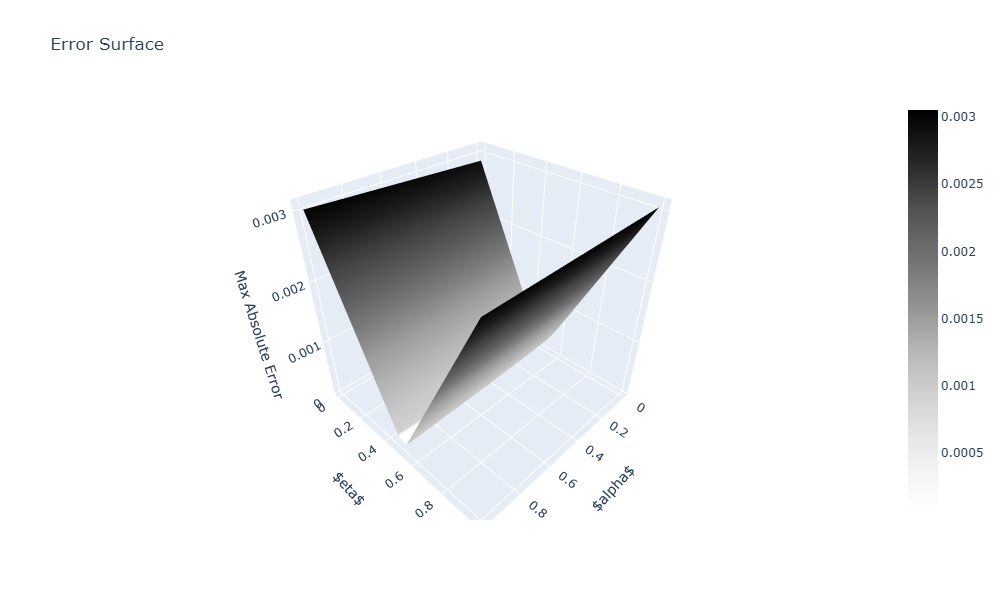

In [7]:
r, sigma, T, Nt, Nx = 0.21, 0.3, 1, 1000, 1 
params = [r, sigma]

alphas = np.linspace(0, 1, 20)
etas = np.linspace(0, 1, 20)

bsm_model = BSMprocess(params, T, Nx, Nt)
runner = ApproximationRunner(bsm_model)

errors = runner.study_alpha_eta(alphas, etas)
runner.plot_error_surface(alphas, etas, errors)


### Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

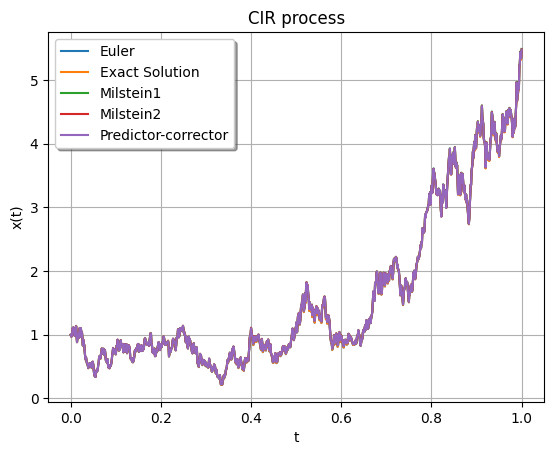

In [8]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

### Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

In [9]:
runner = ApproximationRunner(model)  # Assume model is defined elsewhere with correct methods
levels_of_N = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]
results_df = runner.compare_speed_convergence(levels_of_N)

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="log2(N)", y="Mean Absolute Difference", hue="Method", marker="o")
plt.yscale('log')  # Log scale for y-axis to better observe convergence rates
plt.xlabel("log2(N)")
plt.ylabel("Mean Absolute Difference (log scale)")
plt.title("Mean Absolute Error vs. Discretization Steps (log scale)")
plt.legend(title="Method")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


### Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [10]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

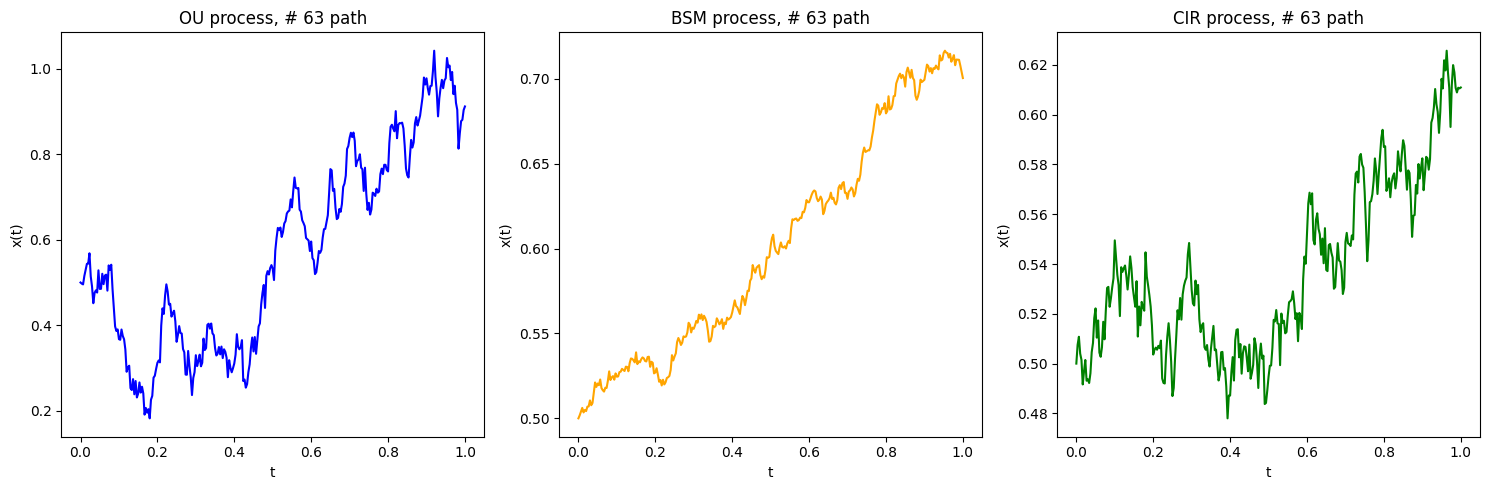

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

### Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

In [12]:
class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.theta = self.params[0]
        self.dt = T / Nt  # Define dt based on the total time T and number of time steps Nt

    def DefaultInitState(self):
        return np.ones(self.Nx) * 0.5

    def StationaryState(self):
        return np.random.uniform(0, 1, size=self.Nx)

    def SampleFromDensity(self, x0, t1, t0):
        dW = np.random.normal(0, 1, size=self.Nx) * np.sqrt(self.dt)  # Adjust dW based on self.dt

        result = np.zeros(self.Nx)

        for i in range(self.Nx):
            # Apply the SDE: dXt = -θ Xt−1 dt + θ Xt(1 − Xt) dW
            result[i] = x0[i] + (-self.theta * x0[i] * self.dt + 
                                 self.theta * x0[i] * (1 - x0[i]) * dW[i])
            # Ensure the result is within the unit interval
            result[i] = np.clip(result[i], 0, 1)

        return result


In [13]:
theta1 = 1.5
params = [theta1]
T = 1  # Time horizon
Nx, Nt = 1, 1000  
dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

jacobi_process = JacobiProcess(params, T, Nx, Nt)

plt.figure(figsize=(10, 6))

t_data, x_data_Jacobi = jacobi_process.EulerSolution(dwt)
plt.plot(t_data, x_data_Jacobi, label=f'Jacobi Euler Solution')

plt.title("Jacobi Process")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("Time (t)")
plt.ylabel("Value (x(t))")
plt.grid(True)
plt.show()


### Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [14]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]
params_jacobi = [1.5]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)
jacobi_process = JacobiProcess(params_jacobi, T, Nx, Nt)


t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()
t_data, x_data_Jacobi = jacobi_process.PathGenerator()

In [15]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

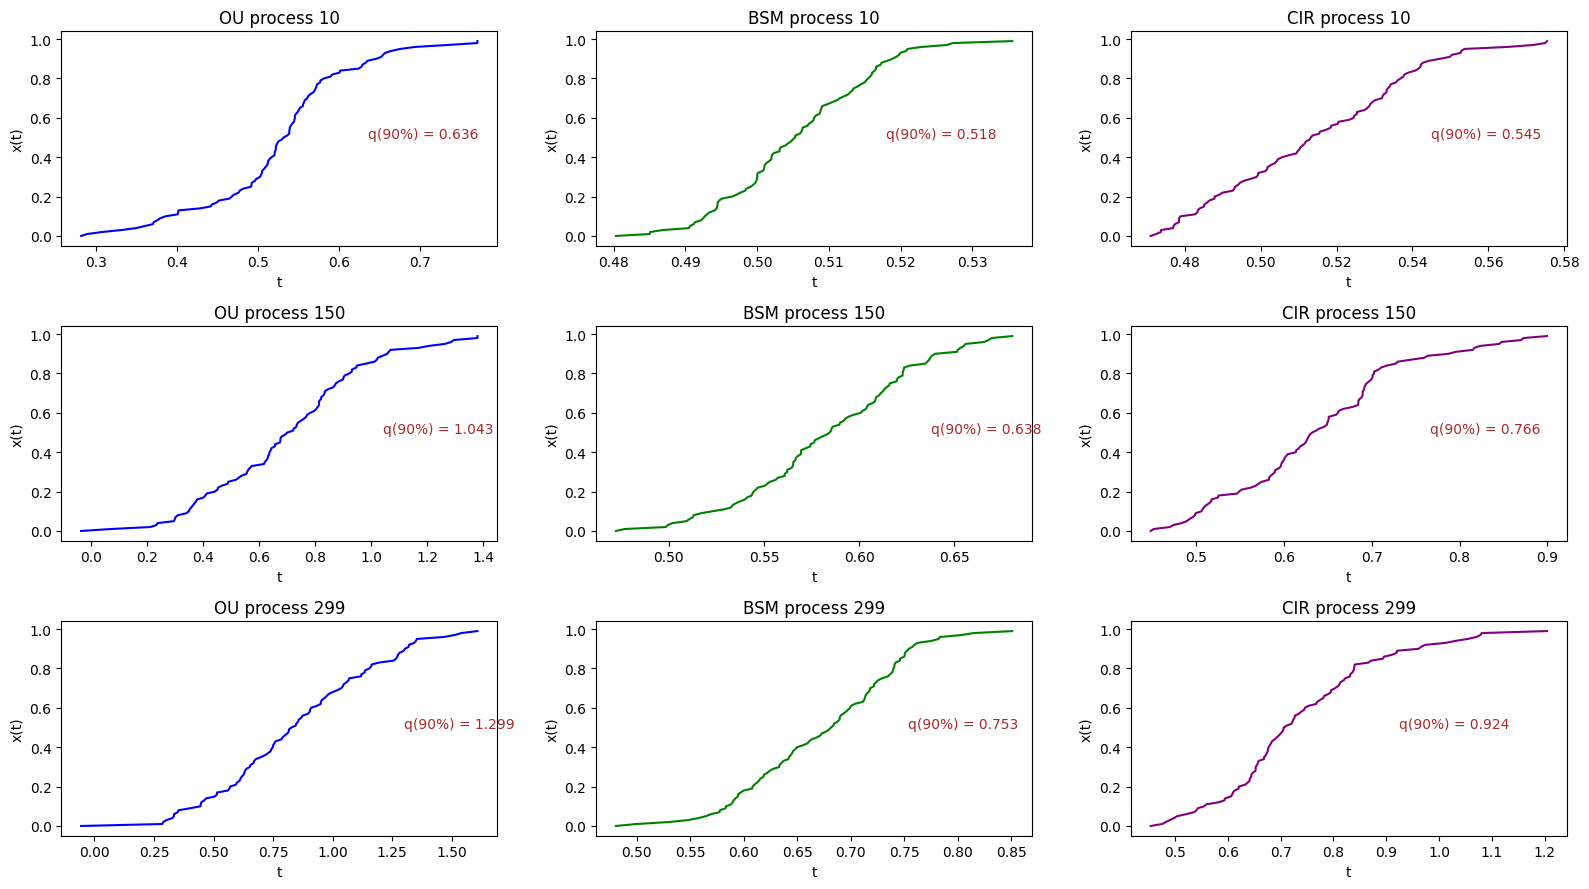

In [16]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

### Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

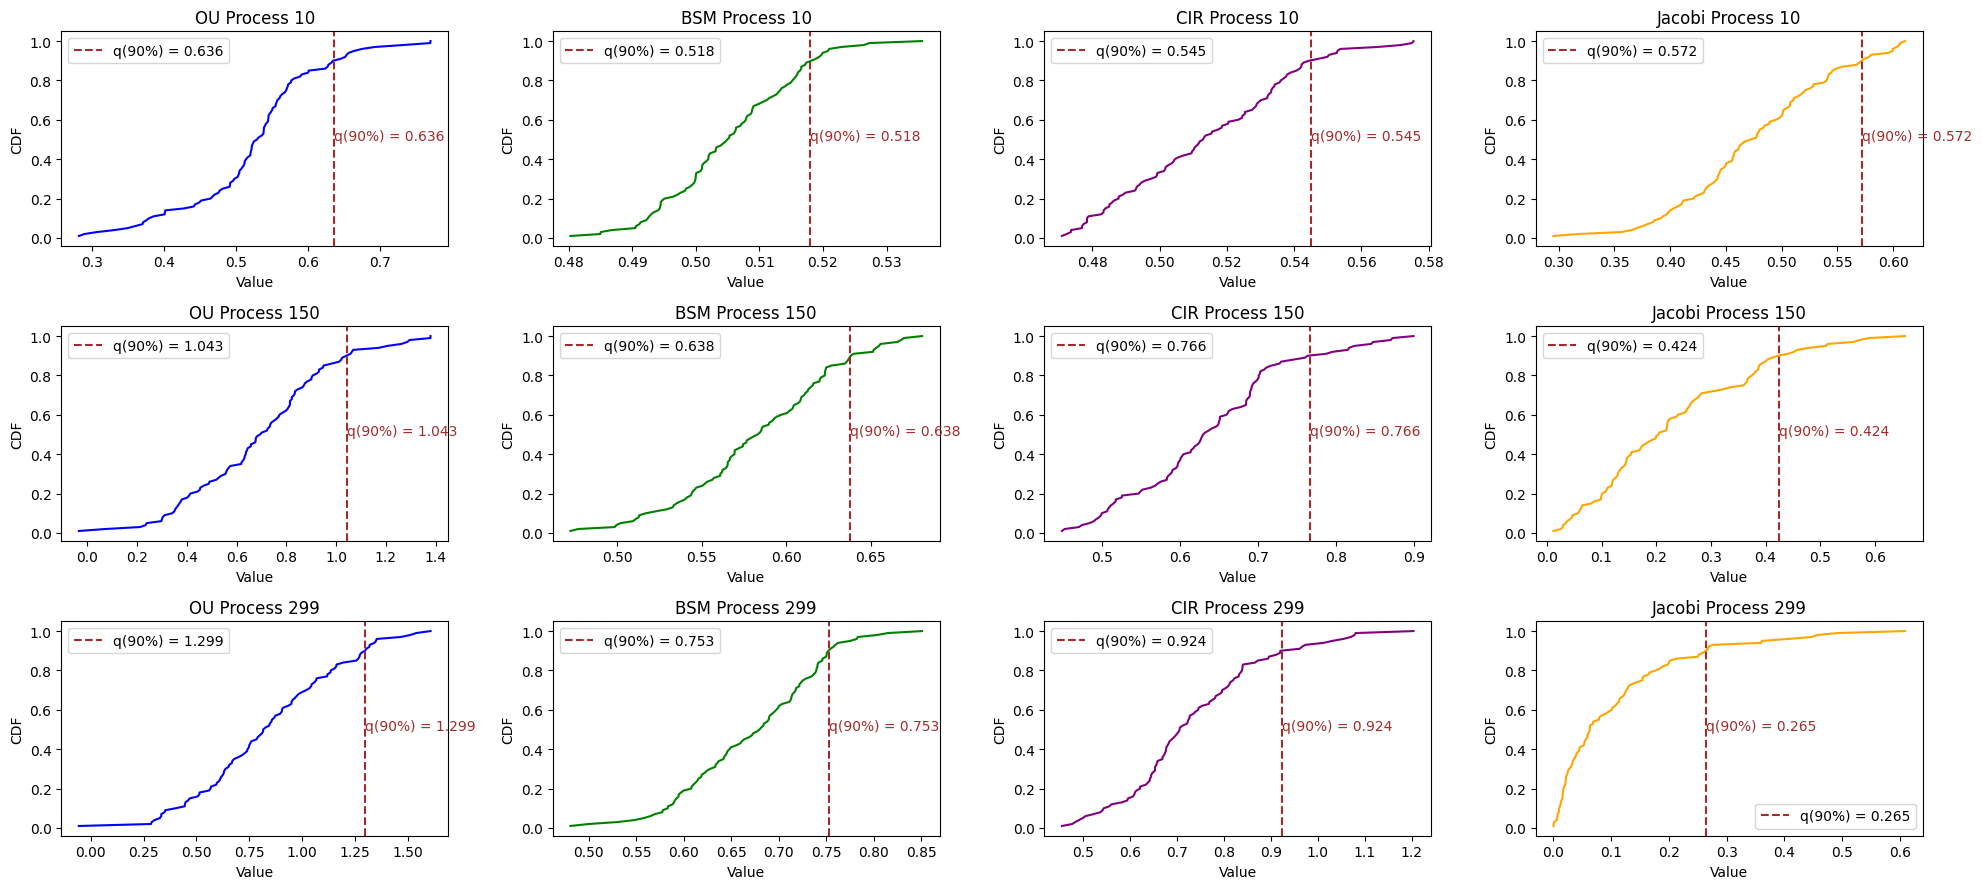

In [17]:



def ecdf(data):
    sorted_data = np.sort(data)
    cdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf_y

fig, axs = plt.subplots(3, 4, figsize=(20, 9))

time_points = [10, Nt // 2, Nt - 1]

def plot_process_cdf(ax, data, color, title, label):
    sorted_data, cdf_y = ecdf(data)
    quantile_90 = round(np.quantile(data, 0.9), 3)
    ax.plot(sorted_data, cdf_y, color=color)
    ax.axvline(quantile_90, color='brown', linestyle='--', label=f'q(90%) = {quantile_90}')
    ax.set_title(title)
    ax.text(quantile_90, 0.5, f"q(90%) = {quantile_90}", color='brown')
    ax.set_xlabel('Value')
    ax.set_ylabel('CDF')
    ax.legend()

for i, n in enumerate(time_points):
    # OU Process
    plot_process_cdf(axs[i][0], x_data_OU[n], color='blue', title=f'OU Process {n}', label='OU')

    # BSM Process
    plot_process_cdf(axs[i][1], x_data_BSM[n], color='green', title=f'BSM Process {n}', label='BSM')

    # CIR Process
    plot_process_cdf(axs[i][2], x_data_CIR[n], color='purple', title=f'CIR Process {n}', label='CIR')

    # Jacobi Process
    plot_process_cdf(axs[i][3], x_data_Jacobi[n], color='orange', title=f'Jacobi Process {n}', label='Jacobi')

plt.tight_layout()
plt.show()


In [18]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 50)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

### Task. Perform a normality test on the histograms and present your conclusions.

In [19]:


def plot_density_and_tests(x_data_dict, Nt):
    """
    Plots histograms, fits normal distributions, and conducts statistical tests for given models.
    
    Parameters:
        x_data_dict (dict): Dictionary containing the models' data arrays.
        Nt (int): Number of time points used for the histogram plots.
    """
    
    fig, axs = plt.subplots(3, 4, figsize=(20, 9))  
    ns = [10, Nt // 2, Nt - 1]
    
    models = ['OU', 'BSM', 'CIR', 'Jacobi']
    colors = ['blue', 'green', 'purple', 'orange']
    
    x_data_OU = x_data_dict['OU']
    x_data_BSM = x_data_dict['BSM']
    x_data_CIR = x_data_dict['CIR']
    x_data_Jacobi = x_data_dict['Jacobi']

    for k, n in enumerate(ns):
        for j, (model_data, model_name, color) in enumerate(zip(
            [x_data_OU, x_data_BSM, x_data_CIR, x_data_Jacobi],
            models, colors)):
            
            axs[k][j].hist(model_data[n], color=color, density=True, alpha=0.5)
            mu, std = norm.fit(model_data[n])
            
            xmin, xmax = axs[k][j].get_xlim()
            x = np.linspace(xmin, xmax, 100)  # Increase the number of points for a smoother curve
            p = norm.pdf(x, mu, std)
            axs[k][j].plot(x, p, color='black')  # Fit line
            
            axs[k][j].text(0.1, 0.8, f'mu={mu:.3f}\nstd={std:.3f}', color='black', 
                           transform=axs[k][j].transAxes)

            # Shapiro test
            stat, p_value = shapiro(model_data[n])
            axs[k][j].text(0.7, 0.7, f'Shapiro-Wilk p-value: {p_value:.3f}', color='brown', 
                           transform=axs[k][j].transAxes)

            # Kolmogorov test
            ks_stat, ks_p_value = kstest(model_data[n], 'norm', args=(mu, std))
            axs[k][j].text(0.7, 0.6, f'KS p-value: {ks_p_value:.3f}', color='blue',  
                           transform=axs[k][j].transAxes)

            axs[k][j].set_title(f'{model_name} process {n}')
            axs[k][j].set_xlabel('t')
            axs[k][j].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

x_data_dict = {
    'OU': x_data_OU,
    'BSM': x_data_BSM,
    'CIR': x_data_CIR,
    'Jacobi': x_data_Jacobi  # Ensure this data is available
}

Nt = 100  
plot_density_and_tests(x_data_dict, Nt)
